# Preprocessing of steady-states data

**Author:** M.G. Baltussen

**Estimated running time:** 20 minutes

**Generated output:**
```
plots/steadystate_traces_a.{svg,png}
plots/steadystate_traces_b.{svg,png}
data/steadystates.csv
```

In [1]:
""" System imports """

import pathlib
import toml

""" Essential imports"""
import numpy as np
import pandas as pd

""" ML/RC imports """
from sklearn.feature_selection import mutual_info_regression as mi_reg
from sklearn import linear_model, model_selection, preprocessing, svm
from sklearn import metrics

from pyrcn.echo_state_network import ESNClassifier


""" Visualization imports and settings"""
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

import seaborn as sns

sns.set_theme(
    style="ticks",
    context="paper",
    font_scale=0.7,
    rc={
        "axes.linewidth": 0.5,
        "axes.facecolor": "#eceff4",
        "axes.edgecolor": "#2e3440",
        "axes.labelcolor": "#2e3440",
        "text.color": "#2e3440",
        "xtick.color": "#2e3440",
        "ytick.color": "#2e3440",
        "font.family": "Arial",
        "svg.fonttype": "none",
    },
)
import colorcet as cc

nord_palette = [
    "#bf616a",
    "#d08770",
    "#ebcb8b",
    "#a3be8c",
    "#b48ead",
    "#8fbcbb",
    "#88c0d0",
    "#81a1c1",
    "#5e81ac",
    "#2e3440",
    "#3b4252",
    "#434c5e",
    "#4c566a",
    "#d8dee9",
    "#e5e9f0",
    "#eceff4",
]

sns.set_palette(nord_palette)


def save_plot(name, **kwargs):
    """Helper function to save figures in desired formats and location"""
    plt.savefig(f"../plots/{name}.svg", **kwargs)
    plt.savefig(f"../plots/{name}.png", dpi=300, **kwargs)


def save_si(name, **kwargs):
    """Helper function to save figures in desired formats and location"""
    plt.savefig(f"../plots_extended/{name}.svg", **kwargs)
    plt.savefig(f"../plots_extended/{name}.png", dpi=300, **kwargs)

In [2]:
EXPERIMENTS = ['FTT008', 'FTT009', 'FTT010', 'FTT011', 'FTT012', 'FTT013', 'FTT014', 'FTT015', 'FTT016','FTT017']
flow_parameters = {
    exp: np.array([[c['length'], c['syringe_parameters']['NaOH']['reactor_concentration'], c['syringe_parameters']['formaldehyde']['reactor_concentration']] 
                    for c in toml.load(f"../data/steadystates/{exp}_flow_parameters.toml")['sections']
                ]) for exp in EXPERIMENTS
}

In [3]:
def preprocess(name: str, inputs, fig, axes, OFFSET: int, SS_TIME: int = 600, frac=1):
    """For the specified experiment,
    plot the inputs and corresponding ion traces on the specified axes
    with steady-state regions indicated.
    Returns the steadystate data as a DataFrame together with inputs"""

    # Align inputs with ion signals
    df_inputs = pd.DataFrame(inputs, columns=["time", "NaOH", "Form"]).assign(
        time=np.cumsum(inputs[:, 0]) + OFFSET
    )

    # Concatenate ion signals into 1 DataFrame,
    # round retention time to 1 decimal to standardize time indices
    # and pivot to wide format (species as columns)
    files = pathlib.Path(f"../data/steadystates/{name}/").glob("*.dat")
    df = pd.concat(
        (pd.read_csv(f, sep="\t").assign(species=f.stem) for f in files),
        ignore_index=True,
    )
    df = df.assign(retention_time=df.retention_time.round(1))
    df = df.pivot(index=["retention_time"], columns="species", values="intensity")

    pad_frac = np.array([-0.05, 0.05])
    ranges = np.array([[10, 50], [10, 150]])
    pad = pad_frac * np.diff(ranges, axis=1)
    extends = ranges + pad
    x_extend = extends[0]
    y_extend = extends[1]
    axes[0].set_xlim(*x_extend)
    axes[0].set_ylim(*y_extend)
    axes[0].set_xlabel(r"[NaOH] (mM)")
    axes[0].set_ylabel(r"[Form.] (mM)")

    # Plot experiment ipnuts on first axis and add colorbar to indicate order
    sns.scatterplot(
        ax=axes[0],
        data=df_inputs,
        x="NaOH",
        y="Form",
        hue="time",
        legend=None,
        palette="flare",
    )
    fig.colorbar(
        ax=axes[0],
        mappable=ScalarMappable(
            cmap=sns.color_palette("flare", as_cmap=True),
            norm=Normalize(vmin=df_inputs.time.min(), vmax=df_inputs.time.max()),
        ),
        orientation="vertical",
        location="right",
        shrink=1,
        ticks=df_inputs.time[::2].round(-1),
        label="Time (s)",
    )

    sns.scatterplot(
        data=df.sample(frac=frac),
        legend=None,
        s=0.2,
        alpha=0.1,
        palette=cc.glasbey_dark[: df.shape[1]],
        lw=0,
        rasterized=True,
        ax=axes[1],
    )
    axes[1].vlines(df_inputs.time, 0, 0.12, lw=0.2)
    axes[1].vlines(df_inputs.time - SS_TIME, 0, 0.12, lw=0.2)
    axes[1].set_ylabel("Signal (A.U.)")
    axes[1].set_xlabel("Time (s)")
    axes[1].set_xlim(0, 26000)

    FTT_ss = []
    for idx, input in df_inputs.iterrows():
        start = input.time - SS_TIME
        end = input.time
        data = df.query(f"{start} < retention_time < {end}")
        FTT_ss.append(data.mean())

    FTT_ss = pd.concat(FTT_ss, axis=1).transpose()
    return df_inputs.join(FTT_ss).assign(exp=name)

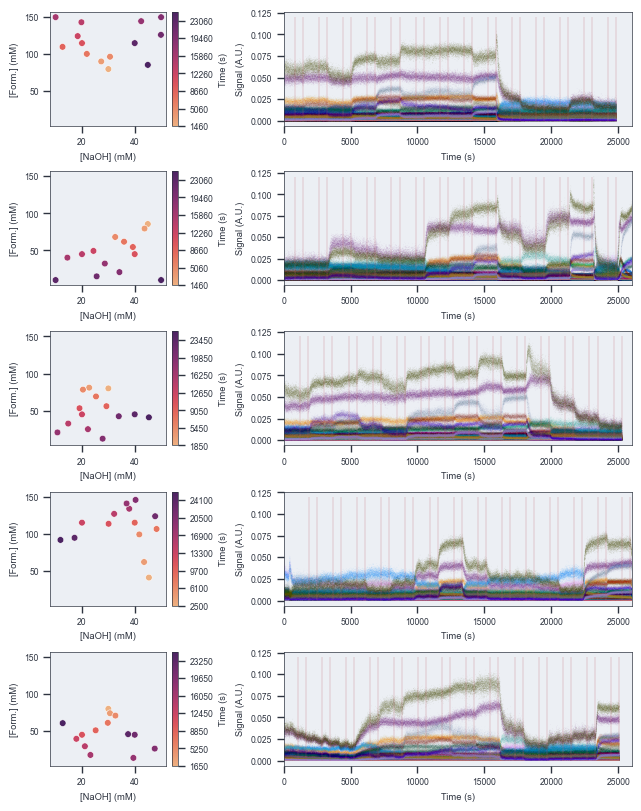

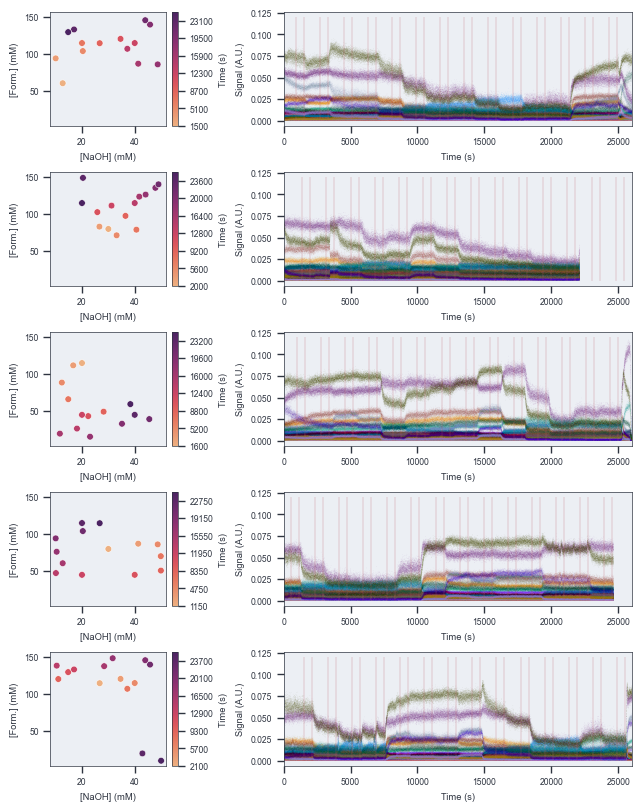

In [4]:
fig, axes = plt.subplots(
    5,
    2,
    figsize=(6.3, 8),
    gridspec_kw={"width_ratios": [1, 3]},
    constrained_layout=True,
)

OFFSETS = {
    "FTT008": 260,
    "FTT009": 260,
    "FTT010": -1750,
    "FTT011": -1100,
    "FTT012": -1950,
    "FTT013": -2100,
    "FTT014": -1600,
    "FTT015": -2000,
    "FTT016": -2450,
    "FTT017": -1500,
}
df_all = []
df_std = []
for i, exp in enumerate(EXPERIMENTS[:5]):
    data_mean = preprocess(exp, flow_parameters[exp], fig, axes[i], OFFSETS[exp])
    df_all.append(data_mean)

save_si(f"steadystate_traces_a")


fig, axes = plt.subplots(
    5,
    2,
    figsize=(6.3, 8),
    gridspec_kw={"width_ratios": [1, 3]},
    constrained_layout=True,
)

for i, exp in enumerate(EXPERIMENTS[5:]):
    data_mean = preprocess(exp, flow_parameters[exp], fig, axes[i], OFFSETS[exp])
    df_all.append(data_mean)

save_si(f"steadystate_traces_b")

In [5]:
""" Remove selected failed steady-states (flow errors) and save processed data"""

import pandas as pd

mz_sorted_compounds = (
    pd.read_csv("compound_label_map.csv", header=None).set_index(0).index.values
)
df_all = (
    pd.concat(df_all).reset_index(drop=True).drop([0, 27, 28, 56, 84, 96, 97, 112])
)  # Drop experiments with potential measurement errors
df_all = pd.concat(
    (df_all[["time", "NaOH", "Form", "exp"]], df_all[mz_sorted_compounds]), axis=1
)
df_all.to_csv("../data/steadystates.csv", index=True)

df_all

,time,NaOH,Form,exp,C4_-H_NaCa_2p,C5_Ca_2p_I1,C5_Ca_2p_I2,C2_Ca_I1,C2_Ca_I2,C6-H2O_Ca_2p_I1,...,C6_Na_I1,C6_Na_I2,C6_Na_I3,C6_Na_I4,C12+H2O_Ca_2p_I1,C12+H2O_Ca_2p_I2,C12+H2O_Ca_2p_I3,C7_Na_I1,C7_Na_I2,C7_Na_I3
1,3260.0,27.2896,90.2669,FTT008,0.000659,0.001250,0.000350,0.000698,0.000209,0.005780,...,0.001239,0.007815,0.012402,0.004235,0.000382,0.001237,0.000197,0.001490,0.000645,0.000454
2,5060.0,30.6315,96.6331,FTT008,0.000664,0.001311,0.000357,0.000565,0.000214,0.005539,...,0.001354,0.008893,0.015463,0.005302,0.000437,0.001282,0.000231,0.001609,0.000722,0.000546
3,6860.0,21.8414,100.4384,FTT008,0.000621,0.001126,0.000302,0.001121,0.000254,0.005532,...,0.001145,0.006483,0.008154,0.002682,0.000307,0.001132,0.000160,0.001315,0.000554,0.000303
4,8660.0,12.6292,109.9410,FTT008,0.000624,0.001123,0.000336,0.003094,0.000674,0.005524,...,0.000979,0.004658,0.002999,0.000740,0.000228,0.000868,0.000107,0.000738,0.000340,0.000162
5,10460.0,20.0000,115.0000,FTT008,0.000619,0.001146,0.000310,0.001414,0.000282,0.005711,...,0.001273,0.006274,0.006797,0.001987,0.000297,0.001109,0.000140,0.001197,0.000523,0.000261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,18300.0,31.6440,148.5580,FTT017,0.000697,0.001455,0.000391,0.000597,0.000209,0.005948,...,0.001386,0.008208,0.014526,0.004985,0.000410,0.001231,0.000230,0.001244,0.000592,0.000429
136,20100.0,43.9860,145.8833,FTT017,0.000554,0.001319,0.000528,0.000427,0.000254,0.003513,...,0.001971,0.011197,0.020694,0.006800,0.000516,0.001119,0.000311,0.001531,0.000841,0.000684
137,21900.0,45.8087,139.9426,FTT017,0.000540,0.001237,0.000557,0.000408,0.000273,0.002897,...,0.002133,0.012047,0.022951,0.007907,0.000521,0.001085,0.000330,0.001648,0.000979,0.000805
138,23700.0,42.9120,19.8840,FTT017,0.001009,0.001955,0.000681,0.000522,0.000331,0.006205,...,0.001575,0.012601,0.010499,0.003918,0.000511,0.000935,0.000413,0.001119,0.001802,0.002746
